In [7]:
import os

directory = "/Users/guozhitong/11711-webarena/data"
output_file = "line_counts.txt"

def count_lines(filename):
    with open(filename, 'r') as file:
        return sum(1 for line in file)

if os.path.isdir(directory):
    with open(output_file, 'w') as out_file:
        for root, dirs, files in os.walk(directory):
            for file in files:
                if file.endswith('.txt') and file.startswith('render') and 'tree' in file:
                    file_path = os.path.join(root, file)
                    line_count = count_lines(file_path)
                    out_file.write(f"{line_count:6} {file_path}\n")
                    if line_count > 400:
                        print(f"{line_count:6} {file_path}")
else:
    print("Directory does not exist.")

   433 /Users/guozhitong/11711-webarena/data/webarena_acc_tree/render_811_tree_3.txt
   435 /Users/guozhitong/11711-webarena/data/webarena_acc_tree/render_811_tree_5.txt
   445 /Users/guozhitong/11711-webarena/data/webarena_acc_tree/render_446_tree_7.txt
   445 /Users/guozhitong/11711-webarena/data/webarena_acc_tree/render_446_tree_6.txt
   435 /Users/guozhitong/11711-webarena/data/webarena_acc_tree/render_811_tree_4.txt
   433 /Users/guozhitong/11711-webarena/data/webarena_acc_tree/render_811_tree_6.txt
   433 /Users/guozhitong/11711-webarena/data/webarena_acc_tree/render_811_tree_7.txt


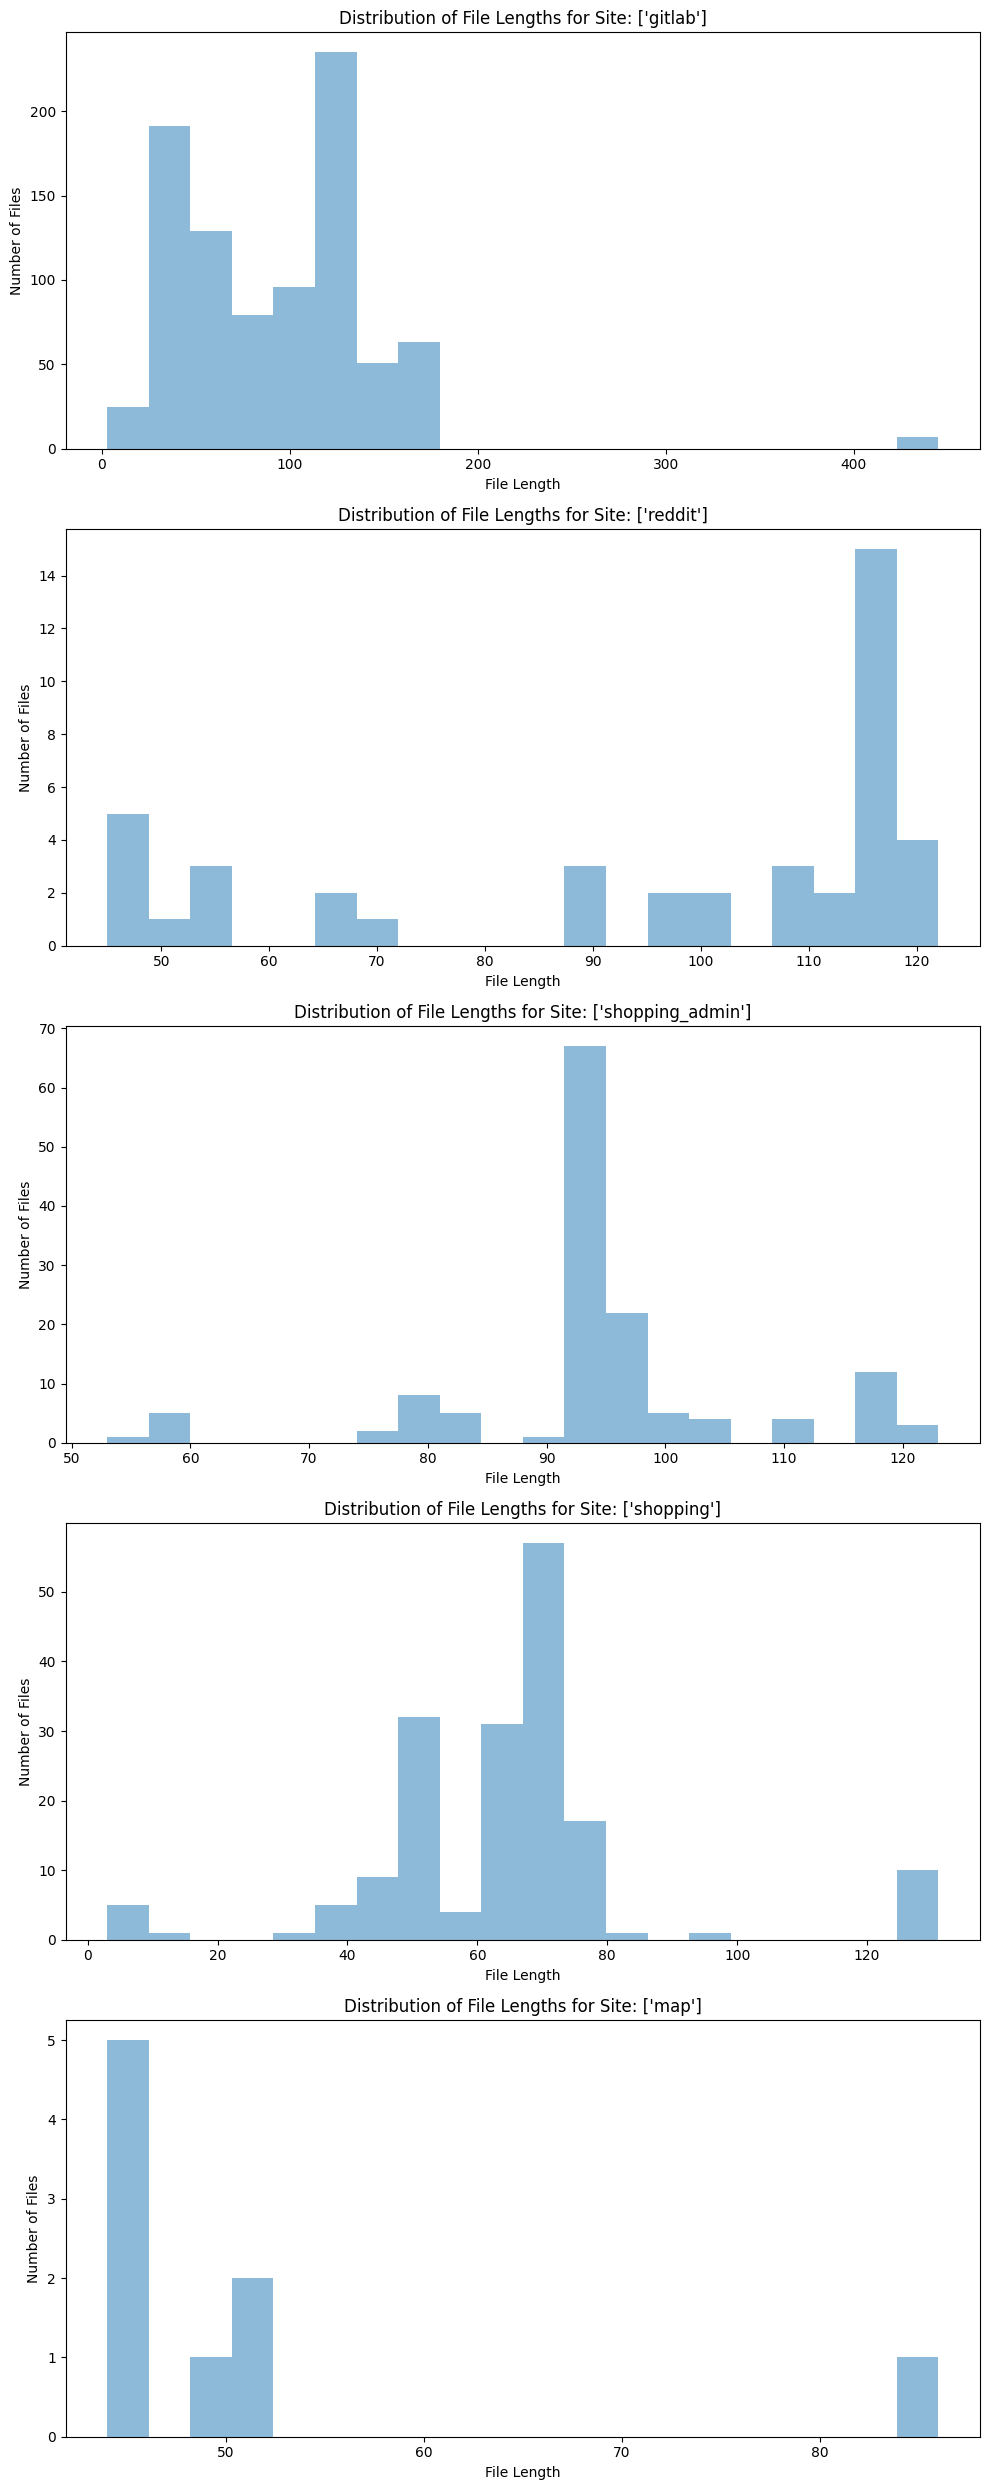

In [32]:
import pandas as pd
import matplotlib.pyplot as plt


metadata_df = pd.read_csv('/Users/guozhitong/11711-webarena/gpt3.5_baseline_metadata.csv')
task_to_site = dict(zip(metadata_df['task_id'], metadata_df['sites']))
sites = ["['shopping_admin']", "['map']", "['shopping']", "['reddit']", "['gitlab']"]

def extract_task_id(filename):
    parts = filename.split('_')
    if len(parts) > 1 and parts[0] == 'render':
        return int(parts[1])
    return None

directory = "/Users/guozhitong/11711-webarena/data"
file_lengths = {}  

for root, dirs, files in os.walk(directory):
    for file in files:
        if file.endswith('.txt') and file.startswith('render') and 'tree' in file:
            task_id = extract_task_id(file)
            if task_id and task_id in task_to_site:
                site = task_to_site[task_id]
                file_path = os.path.join(root, file)
                with open(file_path, 'r') as f:
                    line_count = sum(1 for line in f)
                if site not in file_lengths:
                    file_lengths[site] = []
                file_lengths[site].append(line_count)

del file_lengths["['gitlab', 'reddit']"]
del file_lengths["['wikipedia', 'map']"]

n_sites = len(file_lengths)
fig, axes = plt.subplots(n_sites, 1, figsize=(10, 5 * n_sites))  



for ax, (site, lengths) in zip(axes, file_lengths.items()):
    ax.hist(lengths, bins=20, alpha=0.5)
    ax.set_title(f'Distribution for Site: {site}')
    ax.set_xlabel('# of Elements in Trees')
    ax.set_ylabel('Number of Acc Trees')

plt.tight_layout()
plt.show()

##save plot
fig.savefig('distribution_of_file_lengths.png')


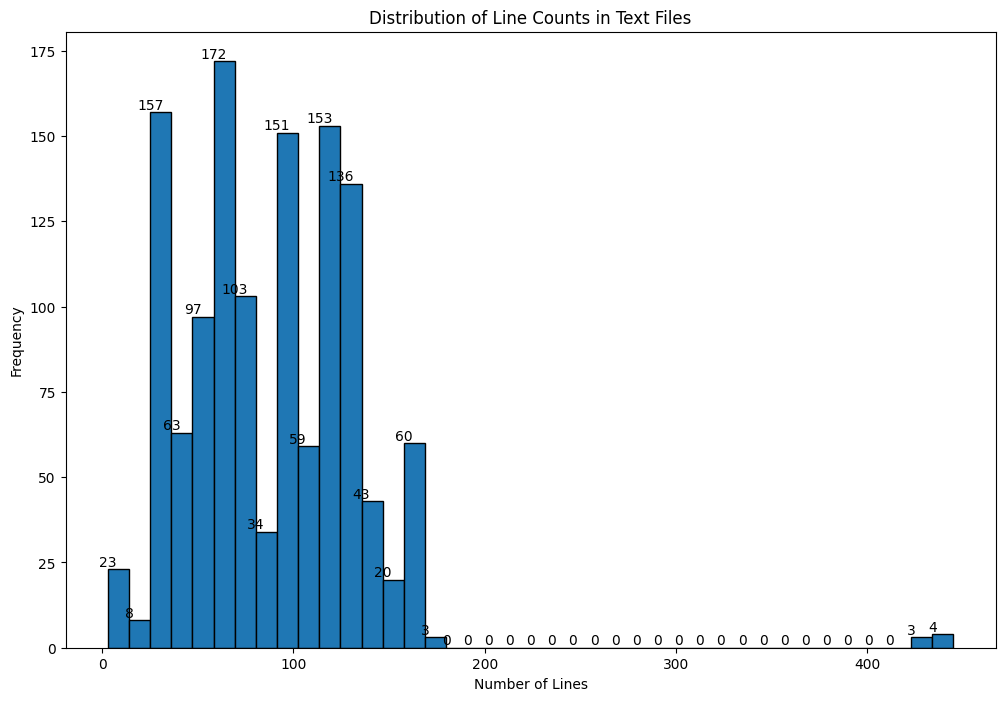

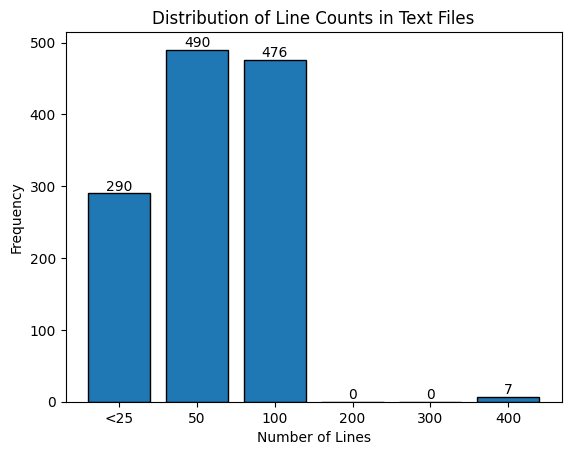

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def read_line_counts(filename):
    line_counts = []
    with open(filename, 'r') as file:
        for line in file:
            count, _ = line.split(maxsplit=1)
            line_counts.append(int(count))
    return line_counts

def plot_distribution(line_counts):
    n, bins, patches = plt.hist(line_counts, bins=40, edgecolor='black')
    
    #change plot size
    fig = plt.gcf()
    fig.set_size_inches(12, 8)
    
    for count, bin in zip(n, bins):
        plt.text(bin, count, str(int(count)), ha='center', va='bottom')

    plt.title('Distribution of Line Counts in Text Files')
    plt.xlabel('Number of Lines')
    plt.ylabel('Frequency')
    plt.show()

def plot_distribution_customize(line_counts):
    bin_ranges = [25, 50, 100, 200, 300, 400, 500]
    bin_labels = ['<25', '50', '100', '200', '300', '400']

    counts, _ = np.histogram(line_counts, bins=bin_ranges)

    plt.bar(bin_labels, counts, edgecolor='black')

    for label, count in zip(bin_labels, counts):
        plt.text(label, count, str(count), ha='center', va='bottom')

    plt.title('Distribution of Line Counts in Text Files')
    plt.xlabel('Number of Lines')
    plt.ylabel('Frequency')
    plt.show()

if __name__ == "__main__":
    counts = read_line_counts("line_counts.txt")
    plot_distribution(counts)
    plot_distribution_customize(counts)


In [19]:
import pandas as pd


data = pd.read_csv('/Users/guozhitong/11711-webarena/gpt3.5_baseline_metadata.csv', index_col=0)
data.columns

Index(['sites', 'task_id', 'require_login', 'storage_state', 'start_url',
       'geolocation', 'intent_template', 'instantiation_dict', 'intent',
       'require_reset', 'eval', 'intent_template_id', 'string_note', 'result'],
      dtype='object')

In [35]:
sites = ["['shopping_admin']", "['map']", "['shopping']", "['reddit']", "['gitlab']"] # only select non-cross-site intents

filtered_data = data[data['sites'].isin(sites) & (data['result'] == 'FAIL')]

sampled_data = filtered_data.groupby('intent_template_id').apply(
    lambda x: x.sample(n=1)
).reset_index(drop=True)

if len(sampled_data) < 100:
    additional_samples = 100 - len(sampled_data)
    sampled_data = pd.concat([
        sampled_data,
        filtered_data[~filtered_data.index.isin(sampled_data.index)].sample(n=additional_samples)
    ])


In [42]:
task_list = sorted(sampled_data['task_id'].to_list())

with open('task_list.txt', 'w') as f:
    for item in task_list:
        f.write("%s\n" % item)

In [20]:
reddit_data = data[data['sites'] == "['reddit']"]
reddit_data = reddit_data[reddit_data['result'] == 'FAIL']

sample_size = 10
reddit_sample = reddit_data.sample(n=sample_size)

reddit_task_list = reddit_sample['task_id'].to_list()

with open('reddit_task_list.txt', 'w') as f:
    for item in reddit_task_list:
        f.write("%s\n" % item)

    k    recall
0   1  0.033816
1   5  0.178744
2  10  0.309179
3  50  0.632850


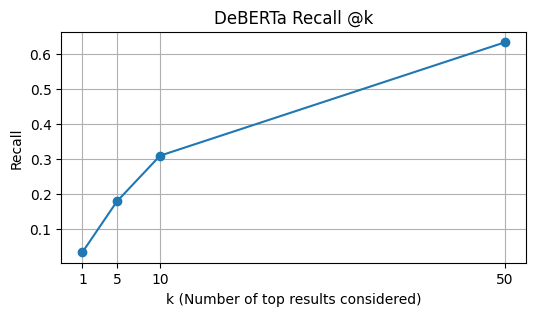

In [48]:
import pandas as pd
df = pd.read_csv("/Users/guozhitong/11711-webarena/deberta_api/deberta_recall_webarena.csv")

recall_at_1 = df['correct_1'].mean()
recall_at_5 = df['correct_5'].mean()
recall_at_10 = df['correct_10'].mean()
recall_at_50 = df['correct_50'].mean()  



k_values = [1, 5, 10, 50]
recall_values = [recall_at_1, recall_at_5, recall_at_10, recall_at_50]
# make a table out of recall_values and k_values
recall_table = pd.DataFrame({'k': k_values, 'recall': recall_values})
print(recall_table)



plt.figure(figsize=(6, 3))
plt.plot(k_values, recall_values, marker='o')
plt.title('DeBERTa Recall @k')
plt.xlabel('k (Number of top results considered)')
plt.ylabel('Recall')
plt.xticks(k_values)
plt.grid(True)
plt.show()




    k    recall
0   1  0.057143
1   5  0.142857
2  10  0.223810
3  50  0.466667


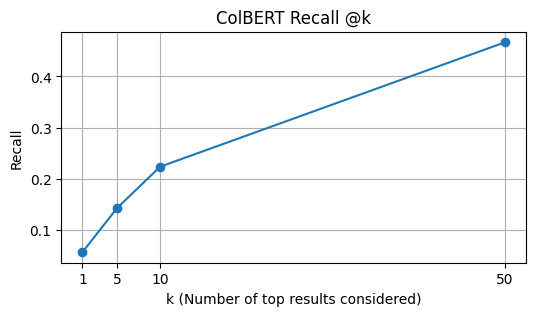

In [47]:
df = pd.read_csv("/Users/guozhitong/11711-webarena/colbert_inference/colbert_recall_webarena.csv")

recall_at_1 = df['correct_1'].mean()
recall_at_5 = df['correct_5'].mean()
recall_at_10 = df['correct_10'].mean()
recall_at_50 = df['correct_50'].mean()  

k_values = [1, 5, 10, 50]
recall_values = [recall_at_1, recall_at_5, recall_at_10, recall_at_50]
# make a table out of recall_values and k_values
recall_table = pd.DataFrame({'k': k_values, 'recall': recall_values})
print(recall_table)

plt.figure(figsize=(6, 3))
plt.plot(k_values, recall_values, marker='o')
plt.title('ColBERT Recall @k')
plt.xlabel('k (Number of top results considered)')
plt.ylabel('Recall')
plt.xticks(k_values)
plt.grid(True)
plt.show()

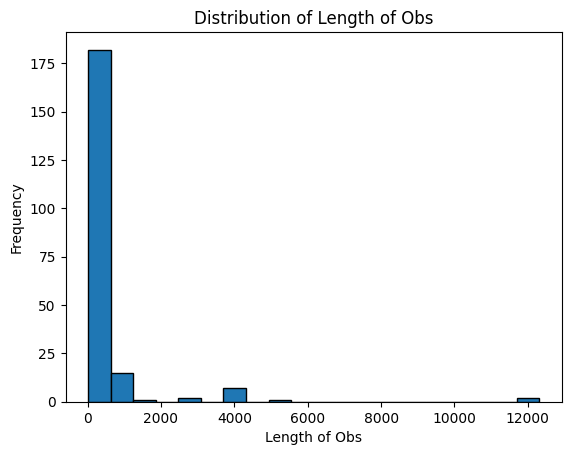

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


df = pd.read_csv("/Users/guozhitong/11711-webarena/data/colbert_recall_webarena.csv")

# add a column to df that contains the length of each obs split by "\n"
df['obs_len'] = df['obs'].apply(lambda x: len(x.split("\n")))

#plot the distribution of length of df['obs']
plt.hist(df['obs_len'], bins=20, edgecolor='black')
plt.title('Distribution of Length of Obs')
plt.xlabel('Length of Obs')
plt.ylabel('Frequency')
plt.show()



In [11]:
df['obs_len'].unique()

array([  342,   722,    86,   154,   167,   122,    26,   336,   326,
         348,   135,   139,   429,   426,   146,   325,   314,    44,
          78,    79,   175,   312, 12307,  5192,    84,    97,    32,
          30,   329,   138,   112,    69,   370,    33,   148,   147,
         166,   143,   233,   264,   703,   632,   634,   865,  4266,
        3787,  1576,    40,    16,   654,   239,   181,   335,   318,
         223,    17,  3872,  3980,   902,  1082,   207,    41,   433,
          46,    47,    39,   330,   659,    43,   192,   165,  4022,
         328,   303,   420,    37,  1032,   627,  2528,   254,   213,
         393,    88,   137,    52,    53,  1120,   186,   136,  1244,
         245])

In [12]:
df.loc[df['obs_len'] == 12307, 'obs'].iloc[0]

'[1] RootWebArea \'Boston Celtics all-time roster\' focused: True\n\t[1170] textbox "Search \'Wikipedia\'" required: False\n\t[1164] checkbox \'\' checked: false\n\t[1172] link \'Go to welcome page\'\n\t[1173] link "Go to the main page of \'Wikipedia\'"\n\t\t[1179] button \'Wikipedia\'\n\t[1174] link \'Go to a randomly selected page\'\n\t[1184] heading \'Boston Celtics all-time roster\' hasPopup: menu\n\t[1189] StaticText \'The following is a \'\n\t[1191] StaticText \'list of players\'\n\t[1192] StaticText \', both past and current, who appeared in at least one regular season or playoff game for the \'\n\t[1193] link \'Boston Celtics\'\n\t[1195] link \'NBA\'\n\t[1196] StaticText \' franchise.\'\n\t\t[11] DisclosureTriangle \'Players\' expanded: True\n\t\t\t[1197] heading \'Players\'\n\t\t\t\t[1235] LayoutTableCell \'G\'\n\t\t\t\t[1236] LayoutTableCell \'Guard\'\n\t\t\t\t\t[1806] link \'Guard\'\n\t\t\t\t[1237] LayoutTableCell \'G/F\'\n\t\t\t\t[1238] LayoutTableCell \'Guard-forward\'\n\t